# Analyze DTW distance against various action patterns

This experiment shows how DTW distance (assuming here that potential reward function would linearly depend on DTW) changes if the agent behaviour shifts from optimal (agent's actions (articulatory movements) perfectly match reference) to completely random following the equation:

$$ a = \gamma * a^{*} + (1-\gamma) * \epsilon $$

Parameter $\gamma$ controls the trade-off between true actions $a^*$ and noise $\epsilon$. We vary $\gamma$ from 1.0 to 0.0 
and run the agent multiple times and then plot how DTW distance is changing over time (in timesteps) for each $\gamma$.

General idea is that 'good' actions ($\gamma = 1.0$) should have DTW distance smaller than its counterpart 'bad' actions ($\gamma=0.0$)

In [74]:
import json
import yaml
from pprint import pprint
import datetime
import copy
import os
import pickle
from collections import defaultdict
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from src.reinforcement_v2.envs.env import EnvironmentManager

from src.reinforcement_v2.utils.timer import Timer
# from src.reinforcement_v2.common.tensorboard import DoubleSummaryWriter
# from src.common.nn import SoftQNetwork, PolicyNetwork
# from src.common.noise import OUNoise
# from src.common.replay_buffer import ReplayBuffer
from src.siamese_net_sound_similarity.train_v2 import SiameseDeepLSTMNet
import dtwalign
from scipy.io.wavfile import read


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline


In [75]:
NUM_ARTICULATORS = 30

In [119]:
with open('DTW_env_test.yaml', 'r') as data_file:
    params = yaml.safe_load(data_file)
    pprint(params)
dist_params = params['env']['distance']

{'env': {'distance': {'dist': 'euclidean',
                      'name': 'dtwalign',
                      'open_end': True,
                      'step_pattern': 'typeIc'},
         'env_id': 'dtw_we_vtl',
         'lib_path': 'C:/Study/SpeechAcquisitionModel/src/VTL/VocalTractLab2.dll',
         'max_episode_duration': 1000,
         'norm_action': False,
         'norm_observation': True,
         'num_workers': 5,
         'preproc_net': {'device': 'cuda',
                         'output_dim': 32,
                         'preproc_net_fname': 'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_25_2019_01_55_PM/net_0.4609375.net'},
         'preprocessing_params': {'name': 'AudioPreprocessorMFCCDeltaDelta',
                                  'numcep': 13,
                                  'sample_rate': 22050,
                                  'winlen': 0.02,
                                  'winstep': 0.01},
         'references': ['C:/Study/SpeechAcquisitionModel/src/VTL/refe

In [120]:
dirs = []
for item in os.listdir():
    if item.startswith('gamma'):
        dirs.append(item)
print(dirs)

['gamma_0.00', 'gamma_0.10', 'gamma_0.20', 'gamma_0.30', 'gamma_0.40', 'gamma_0.50', 'gamma_0.60', 'gamma_0.70', 'gamma_0.80', 'gamma_0.90', 'gamma_1.00']


In [121]:
data = []

for dir in dirs:
    gamma = str(dir[-4:])
    print(gamma)
    rollout_fnames = []
    ref_fnames = []
    for f in os.listdir(dir):
        if f.endswith('.pkl'):
            if f.startswith('ref'):
                ref_fnames.append(f)
            else:
                rollout_fnames.append(f)
    
#     print(len(rollout_fnames))
#     print(len(ref_fnames))
    
    for k in range(len(rollout_fnames)):
        assert(ref_fnames[k][4:] == rollout_fnames[k])
        # load rollout
        with open(os.path.join(dir, rollout_fnames[k]), 'rb') as f:
            rollout = pickle.load(f)
            num_timesteps = len(rollout)
        
        # load ref
        with open(os.path.join(dir, ref_fnames[k]), 'rb') as f:
            ref = pickle.load(f)
            
        rollout = np.array(rollout)[:, NUM_ARTICULATORS:]
        sound_class = ref['class']
        
        
        # now compute dtw open end for each timestep
        for t in range(1, num_timesteps):
            s = rollout[:t, :].reshape(-1, ref['acoustics'].shape[-1])
            
            dist = dtwalign.dtw(s, ref['acoustics'], dist=dist_params['dist'], step_pattern=dist_params['step_pattern'],
                         open_end=dist_params['open_end'], dist_only=True).normalized_distance
            
            item = (t, dist, gamma, sound_class)
            data.append(item)
print(len(data))

0.00
0.10
0.20
0.30
0.40
0.50
0.60
0.70
0.80
0.90
1.00
26400


In [122]:
df = pd.DataFrame(data, columns=['time', 'DTW', 'gamma', 'class'])
# , dtype={'gamma': str, 'time':int, 'DTW':float}
df = df.astype({'gamma': 'category'})
print(df.dtypes)

time        int64
DTW       float64
gamma    category
class      object
dtype: object


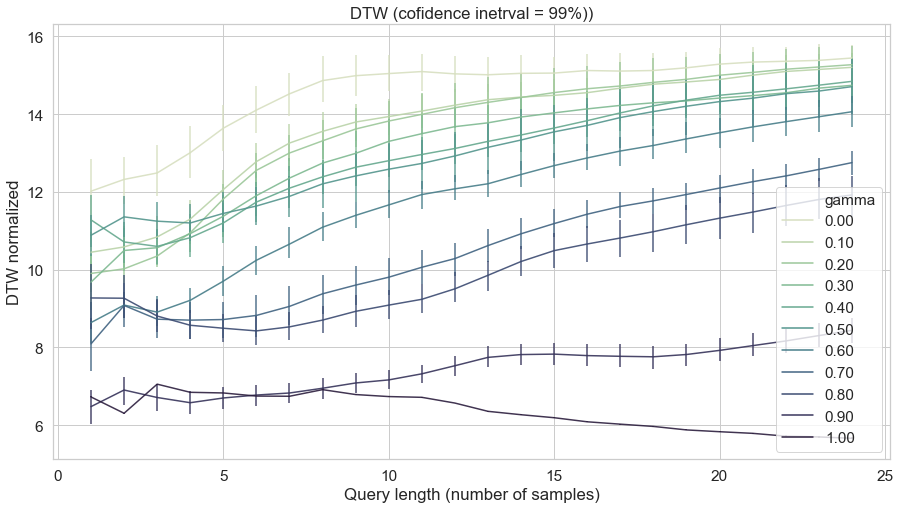

In [123]:
# for i  in range(n_mini_batch_size):
fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'DTW (cofidence inetrval = 99%))')
sns.lineplot(x='time', y='DTW', data=df, ax=axes, alpha=0.9, hue='gamma', ci=99,  err_style="bars",
             palette=sns.cubehelix_palette(len(dirs), start=.5, rot=-.75))
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('DTW normalized')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()

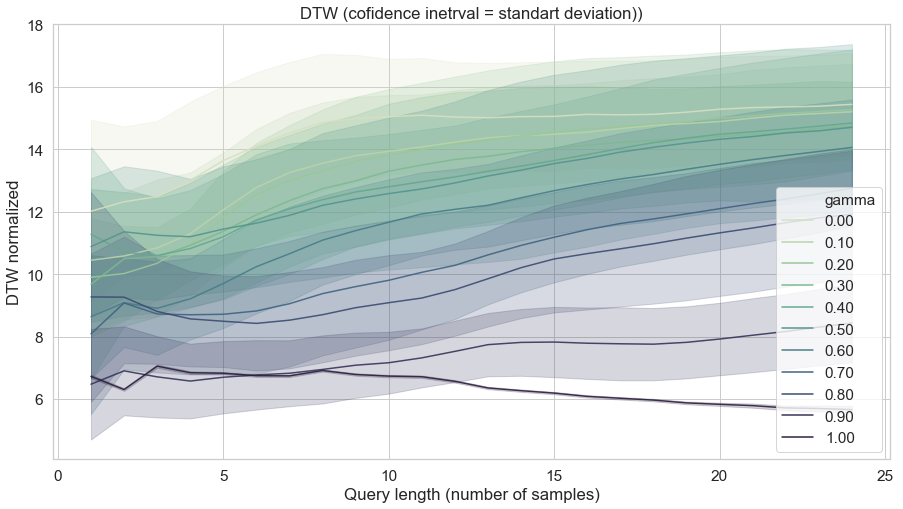

In [124]:
# for i  in range(n_mini_batch_size):
fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'DTW (cofidence inetrval = standart deviation))')
sns.lineplot(x='time', y='DTW', data=df, ax=axes, alpha=0.9, hue='gamma', ci='sd', 
             palette=sns.cubehelix_palette(len(dirs), start=.5, rot=-.75))
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('DTW normalized')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()

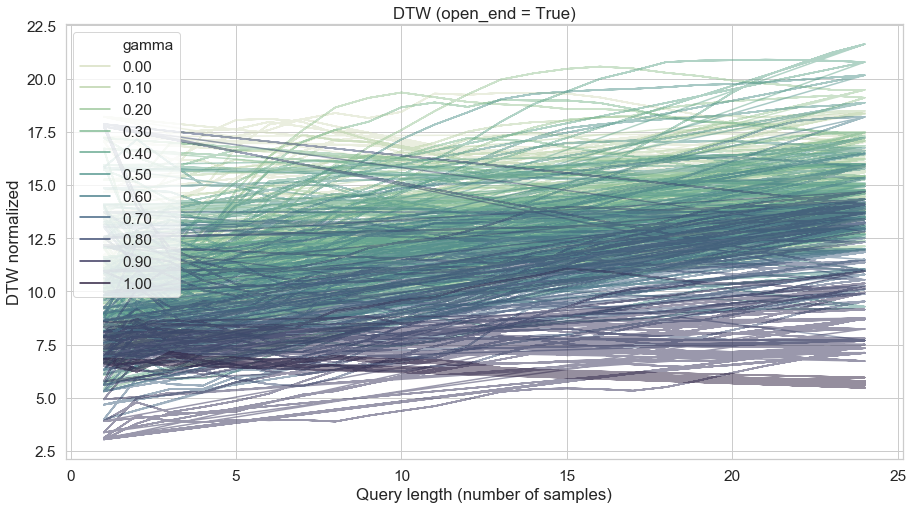

In [125]:
# for i  in range(n_mini_batch_size):
fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'DTW (open_end = True)')
sns.lineplot(x='time', y='DTW', data=df, ax=axes, alpha=0.5, estimator=None, hue='gamma', sort=False, sizes=[0.1],
             palette=sns.cubehelix_palette(len(dirs), start=.5, rot=-.75))
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('DTW normalized')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()